# 猫眼Top100电影爬取

## 爬取HTML

In [1]:
import requests
from bs4 import BeautifulSoup
from pyquery import PyQuery as pq

In [2]:
def get_html(url):
    import requests

    html = requests.get(url)
    return html


url = 'https://maoyan.com/board'
html = get_html(url)
html

<Response [200]>

In [3]:
soup = BeautifulSoup(html.content, 'lxml')
type(soup)

bs4.BeautifulSoup

## DOM解析

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.m97oq52dt4g.png)

In [4]:
soup.find('dd')

<dd>
<i class="board-index board-index-1">1</i>
<a class="image-link" data-act="boarditem-click" data-val="{movieId:1211270}" href="/films/1211270" title="哪吒之魔童降世">
<img alt="" class="poster-default" src="//s3plus.meituan.net/v1/mss_e2821d7f0cfe4ac1bf9202ecf9590e67/cdn-prod/file:5788b470/image/loading_2.e3d934bf.png"/>
<img alt="哪吒之魔童降世" class="board-img" data-src="https://p0.meituan.net/movie/005955214d5b3e50c910d7a511b0cb571445301.jpg@160w_220h_1e_1c"/>
</a>
<div class="board-item-main">
<div class="board-item-content">
<div class="movie-item-info">
<p class="name"><a data-act="boarditem-click" data-val="{movieId:1211270}" href="/films/1211270" title="哪吒之魔童降世">哪吒之魔童降世</a></p>
<p class="star">
                主演：吕艳婷,囧森瑟夫,瀚墨
        </p>
<p class="releasetime">上映时间：2019-07-26</p> </div>
<div class="movie-item-number score-num">
<p class="score"><i class="integer">9.</i><i class="fraction">7</i></p>
</div>
</div>
</div>
</dd>

In [5]:
boards = soup.findAll('dd')

In [6]:
# 电影名称
boards[0].find('p', class_='name').find('a').get('title')

'哪吒之魔童降世'

In [7]:
# 主演
boards[0].find('p', class_='star').contents[0].strip()

'主演：吕艳婷,囧森瑟夫,瀚墨'

In [8]:
# release_time
boards[0].find('p', class_='releasetime').contents[0].strip()

'上映时间：2019-07-26'

In [9]:
# img_url
boards[0].find('img', class_='board-img').get('data-src')

'https://p0.meituan.net/movie/005955214d5b3e50c910d7a511b0cb571445301.jpg@160w_220h_1e_1c'

In [10]:
# 去掉后缀 '@160w_220h_1e_1c'
boards[0].find('img', class_='board-img').get('data-src').split('@')

['https://p0.meituan.net/movie/005955214d5b3e50c910d7a511b0cb571445301.jpg',
 '160w_220h_1e_1c']

带有@160w_220h_1e_1c后缀的图片质量比较低，去掉此后缀后的图片会质量较高
![](https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg@160w_220h_1e_1c)
![](https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg)

In [11]:
# 分数
score_1 = boards[0].find('i', class_='integer').contents[0]
score_2 = boards[0].find('i', class_='fraction').contents[0]
score = f'{float(score_1+score_2):.2}'
score

'9.7'

## 封装函数

In [12]:
def get_movies_pages():
    """
    获取Top100榜
    """
    htmls = {}
    for i in range(0, 100, 10):
        url = f'https://maoyan.com/board/4?offset={i}'
        html = get_html(url)
        htmls[i] = html
    return htmls

In [13]:
htmls = get_movies_pages()

In [14]:
def get_movies_list(html):
    """
    获取每页电影列表
    """
    soup = BeautifulSoup(html.content, 'lxml')
    boards = soup.findAll('dd')
    return boards

9, 42 上映日期只有年，没有具体到日

In [15]:
boards = get_movies_list(htmls[0])

In [16]:
def regular_time(time):
    """
    部分电影日期带有国家, 例如：'1994-09-10(加拿大)'
    正则提取日期
    9, 42 上映日期只有年，没有具体到日
    """
    import re
    pattern = '^(([1-9]\d{3})-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1]))'
    try:
        matches = re.match(pattern, time, flags=0).group()
    except Exception as e:
        pattern = '^(([1-9]\d{3})-(0[1-9]|1[0-2]))'
        try:
            matches = re.match(pattern, time, flags=0).group() + '-01'
        except Exception as e:
            pattern = '^(([1-9]\d{3}))'
            matches = re.match(pattern, time, flags=0).group() + '-01-01'
    return matches


regular_time('1994')

'1994-01-01'

In [17]:
def download(src, img_name):
    """
    下载图片
    """
    # print('启动下载进程，进程号[%d].' % os.getpid())
    dir = './top_100_posters/' + str(img_name) + '.jpg'
    try:
        pic = requests.get(src, timeout=10)
        fp = open(dir, 'wb')
        fp.write(pic.content)
        fp.close()
        return '开始下载:' + str(img_name), src
    except requests.exceptions.ConnectionError as e:
        return e, 'ConnectionError:' + str(img_name) + 'download failed.'
    except OSError as e:
        return e, 'OSError:' + str(img_name) + 'download failed.'


src = 'https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg'
ranking = 1
# download(src, ranking)

In [18]:
def get_movies_info(boards, movie_info, offset):
    """
    获取电影的名字，演员，分数，上映时间，海报url
    movie_info: 电影信息存储容器
    """
    import re
    for i in range(len(boards)):
        title = boards[i].find('p', class_='name').find('a').get('title')
        stars = boards[i].find('p', class_='star').contents[0].strip()[3:]
        score_1 = boards[i].find('i', class_='integer').contents[0]
        score_2 = boards[i].find('i', class_='fraction').contents[0]
        score = float(score_1 + score_2)
        release_time = boards[i].find(
            'p', class_='releasetime').contents[0].strip()[5:]
        release_time = regular_time(release_time)
        img_url = boards[i].find(
            'img', class_='board-img').get('data-src').split('@')[0]
        ranking = offset + i + 1
        movie_info[ranking] = {
            'ranking': ranking,
            'title': title,
            'stars': stars,
            'score': score,
            'release_time': release_time,
            'img_url': img_url
        }

        download(img_url, str(ranking))
    return movie_info

## main()

In [19]:
def main():
    htmls = get_movies_pages()
    movie_info = {}
    for offset in htmls:
        boards = get_movies_list(htmls[offset])
        movie_info = get_movies_info(boards, movie_info, offset)
    return movie_info


if __name__ == '__main__':
    import pprint
    import pandas as pd
    res = main()

## 存入MySQL

In [20]:
from mysql_db import MysqlDB
mysql = MysqlDB()

In [21]:
# 建库 maoyan
sql = "create database maoyan character set utf8;"
mysql.db_execute_one(sql)

{'error': 'Exception error: (1007, "Can\'t create database \'maoyan\'; database exists")'}

![image](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.f9r5v5yvnas.png)

In [22]:
# 建表 top_100
mysql = MysqlDB('maoyan')
# DROP TABLE IF EXISTS `top_100`;
sqls = """
CREATE TABLE `top_100` (
`id` INT ( 11 ) auto_increment NOT NULL,
`ranking` INT ( 11 ) NOT NULL,
`title` VARCHAR ( 255 ) NOT NULL,
`stars` VARCHAR ( 255 ) NOT NULL,
`release_time` VARCHAR ( 255 ) NOT NULL,
`score` FLOAT ( 3, 1 ) NOT NULL,
`img_url` VARCHAR ( 255 ) NOT NULL,
PRIMARY KEY ( `id` ) USING BTREE,
UNIQUE INDEX `title` ( `title` ) USING BTREE 
) ENGINE = INNODB CHARACTER 
SET = utf8;
"""
# sqls  = sqls.split(';')
# for sql in sqls:
#     print(mysql.db_execute_one(sql))
mysql.db_execute_one(sqls)

{'error': 'Exception error: (1050, "Table \'top_100\' already exists")'}

In [24]:
movies_list = []

for movie in res.values():
    infos = [
        movie['ranking'], movie['title'], movie['stars'],
        movie['release_time'], movie['score'], movie['img_url']
    ]
    movies_list.append(tuple(infos))

In [25]:
sql = "insert into top_100 (ranking, title, stars, release_time, score, img_url) values (%s, %s, %s, %s, %s, %s);"
mysql.db_insert_many(sql, movies_list)

{'error': 'Exception error: (1062, "Duplicate entry \'霸王别姬\' for key \'title\'")'}

In [26]:
sql = "select * from top_100;"
mysql.db_query_df(sql).drop('id', axis=1)

,ranking,title,stars,release_time,score,img_url
0,1,霸王别姬,"张国荣,张丰毅,巩俐",1993-01-01,9.5,https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg
1,2,肖申克的救赎,"蒂姆·罗宾斯,摩根·弗里曼,鲍勃·冈顿",1994-09-10,9.5,https://p0.meituan.net/movie/283292171619cdfd5b240c8fd093f1eb255670.jpg
2,3,罗马假日,"格利高里·派克,奥黛丽·赫本,埃迪·艾伯特",1953-09-02,9.1,https://p0.meituan.net/movie/289f98ceaa8a0ae737d3dc01cd05ab052213631.jpg
3,4,这个杀手不太冷,"让·雷诺,加里·奥德曼,娜塔莉·波特曼",1994-09-14,9.5,https://p1.meituan.net/movie/6bea9af4524dfbd0b668eaa7e187c3df767253.jpg
4,5,泰坦尼克号,"莱昂纳多·迪卡普里奥,凯特·温丝莱特,比利·赞恩",1998-04-03,9.5,https://p1.meituan.net/movie/b607fba7513e7f15eab170aac1e1400d878112.jpg
5,6,唐伯虎点秋香,"周星驰,巩俐,郑佩佩",1993-07-01,9.1,https://p0.meituan.net/movie/da64660f82b98cdc1b8a3804e69609e041108.jpg
6,7,魂断蓝桥,"费雯·丽,罗伯特·泰勒,露塞尔·沃特森",1940-05-17,9.2,https://p0.meituan.net/movie/46c29a8b8d8424bdda7715e6fd779c66235684.jpg
7,8,乱世佳人,"费雯·丽,克拉克·盖博,奥利维娅·德哈维兰",1939-12-15,9.1,https://p0.meituan.net/movie/223c3e186db3ab4ea3bb14508c709400427933.jpg
8,9,天空之城,"寺田农,鹫尾真知子,龟山助清",1992-01-01,9.1,https://p1.meituan.net/movie/ba1ed511668402605ed369350ab779d6319397.jpg
9,10,辛德勒的名单,"连姆·尼森,拉尔夫·费因斯,本·金斯利",1993-12-15,9.2,https://p0.meituan.net/movie/b0d986a8bf89278afbb19f6abaef70f31206570.jpg


### 电影9分以上的电影有哪些 取Top10

In [27]:
sql = """
SELECT * 
FROM `top_100` 
WHERE score > 9
ORDER BY score DESC limit 10;
"""
mysql.db_query_df(sql).drop('id', axis=1)

,ranking,title,stars,release_time,score,img_url
0,59,大话西游之月光宝盒,"周星驰,莫文蔚,吴孟达",2014-10-24,9.6,https://p0.meituan.net/movie/92eb862c42c49f8e41e459c369c4512b226610.jpg
1,1,霸王别姬,"张国荣,张丰毅,巩俐",1993-01-01,9.5,https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg
2,2,肖申克的救赎,"蒂姆·罗宾斯,摩根·弗里曼,鲍勃·冈顿",1994-09-10,9.5,https://p0.meituan.net/movie/283292171619cdfd5b240c8fd093f1eb255670.jpg
3,4,这个杀手不太冷,"让·雷诺,加里·奥德曼,娜塔莉·波特曼",1994-09-14,9.5,https://p1.meituan.net/movie/6bea9af4524dfbd0b668eaa7e187c3df767253.jpg
4,5,泰坦尼克号,"莱昂纳多·迪卡普里奥,凯特·温丝莱特,比利·赞恩",1998-04-03,9.5,https://p1.meituan.net/movie/b607fba7513e7f15eab170aac1e1400d878112.jpg
5,36,疯狂原始人,"尼古拉斯·凯奇,艾玛·斯通,瑞安·雷诺兹",2013-04-20,9.5,https://p1.meituan.net/movie/bc022b86345c643ca21d759166f77a553679589.jpg
6,16,美丽人生,"罗伯托·贝尼尼,尼可莱塔·布拉斯基,乔治·坎塔里尼",1997-12-20,9.3,https://p0.meituan.net/movie/43d259ecbcd53e8bbe902632772281d6327525.jpg
7,21,蝙蝠侠：黑暗骑士,"克里斯蒂安·贝尔,希斯·莱杰,阿伦·伊克哈特",2008-07-18,9.3,https://p0.meituan.net/movie/09658109acfea0e248a63932337d8e6a4268980.jpg
8,27,机器人总动员,"本·贝尔特,艾丽莎·奈特,杰夫·格尔林",2008-06-27,9.3,https://p0.meituan.net/movie/267dd2483f0fb57081474c00fbea38451415571.jpg
9,35,忠犬八公的故事,"Forest,理查·基尔,琼·艾伦",2010-03-12,9.3,https://p0.meituan.net/movie/7787c10ad5e95b03cf83ef9473500d8e282796.jpg


### 2010年以后的电影有哪些  

In [28]:
sql = """
SELECT * 
FROM `top_100` 
WHERE release_time > '2010-01-01'
ORDER BY release_time;
"""
mysql.db_query_df(sql).drop('id', axis=1)

,ranking,title,stars,release_time,score,img_url
0,40,阿凡达,"萨姆·沃辛顿,佐伊·索尔达娜,米歇尔·罗德里格兹",2010-01-04,9.0,https://p1.meituan.net/movie/91f575ec93f019f428d1f33e3ceca7c5115495.jpg
1,35,忠犬八公的故事,"Forest,理查·基尔,琼·艾伦",2010-03-12,9.3,https://p0.meituan.net/movie/7787c10ad5e95b03cf83ef9473500d8e282796.jpg
2,46,驯龙高手,"杰伊·巴鲁切尔,杰拉德·巴特勒,亚美莉卡·费雷拉",2010-05-14,9.0,https://p0.meituan.net/movie/b0d97e4158b47d653d7a81d66f7dd3092146907.jpg
3,50,神偷奶爸,"史蒂夫·卡瑞尔,杰森·席格尔,拉塞尔·布兰德",2010-07-09,9.0,https://p0.meituan.net/movie/85c2bfba6025bfbfb53291ae5924c215308805.jpg
4,60,怦然心动,"玛德琳·卡罗尔,卡兰·麦克奥利菲,艾丹·奎因",2010-08-06,8.9,https://p0.meituan.net/movie/15f1ac49b6d1ff7b71207672993ed6901536456.jpg
5,37,盗梦空间,"莱昂纳多·迪卡普里奥,渡边谦,约瑟夫·高登-莱维特",2010-09-01,9.2,https://p1.meituan.net/movie/2f344a9f9575edbcae9f0abe0578bc90339773.jpg
6,96,我爱你,"宋在浩,李顺才,尹秀晶",2011-02-17,9.0,https://p1.meituan.net/movie/ed50b58bf636d207c56989872a91f4cf305138.jpg
7,65,倩女幽魂,"张国荣,王祖贤,午马",2011-04-30,9.2,https://p1.meituan.net/movie/96d98200d2afb4b87ff189f9c15b6545568339.jpg
8,47,速度与激情5,"范·迪塞尔,保罗·沃克,道恩·强森",2011-05-12,9.2,https://p0.meituan.net/movie/845ce32778a1b3f258de089f91a3979b5766154.jpg
9,64,哈利·波特与死亡圣器（下）,"丹尼尔·雷德克里夫,鲁伯特·格林特,艾玛·沃特森",2011-08-04,9.0,https://p1.meituan.net/movie/bb0eca029cd25329776a4549b3fbe262924727.jpg


### 查询周星驰的电影有哪些

In [29]:
sql = """
SELECT * 
FROM `maoyan`.`top_100` 
WHERE `stars` LIKE '%周星驰%';
"""
mysql.db_query_df(sql).drop('id', axis=1)

,ranking,title,stars,release_time,score,img_url
0,6,唐伯虎点秋香,"周星驰,巩俐,郑佩佩",1993-07-01,9.1,https://p0.meituan.net/movie/da64660f82b98cdc1b8a3804e69609e041108.jpg
1,11,喜剧之王,"周星驰,莫文蔚,张柏芝",1999-02-13,9.1,https://p1.meituan.net/movie/18e3191039d5e71562477659301f04aa61905.jpg
2,59,大话西游之月光宝盒,"周星驰,莫文蔚,吴孟达",2014-10-24,9.6,https://p0.meituan.net/movie/92eb862c42c49f8e41e459c369c4512b226610.jpg
3,75,大话西游之大圣娶亲,"周星驰,朱茵,莫文蔚",2014-10-24,8.8,https://p1.meituan.net/movie/dc2246233a6f5ac1e34c7176b602c8ca174557.jpg


## 存入MongoDB

In [30]:
def load_config():
    import json
    with open("config.json") as config:
        return json.load(config) 

In [31]:
def mongo_db(db_name):
    from pymongo import MongoClient
    client = MongoClient(f'{load_config()["host"]}:27017')
    mongo = client[db_name]
    return mongo


mongo = mongo_db('maoyan')

MongoDB插入数据之后，每个元素会增加`_id`的字段，为了后面继续用原始结果，MongoDB入库之前，将数据深拷贝一份。

In [32]:
import copy
res_deep_copy = copy.deepcopy(res)
list_to_mongo = [res_deep_copy[i] for i in res_deep_copy]
list_to_mongo[0]

{'ranking': 1,
 'title': '霸王别姬',
 'stars': '张国荣,张丰毅,巩俐',
 'score': 9.5,
 'release_time': '1993-01-01',
 'img_url': 'https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg'}

In [33]:
res_deep_copy[1]

{'ranking': 1,
 'title': '霸王别姬',
 'stars': '张国荣,张丰毅,巩俐',
 'score': 9.5,
 'release_time': '1993-01-01',
 'img_url': 'https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg'}

In [34]:
mongo.top_100.drop()
mongo.top_100.insert_many(list_to_mongo)

In [35]:
res_deep_copy[1]

{'ranking': 1,
 'title': '霸王别姬',
 'stars': '张国荣,张丰毅,巩俐',
 'score': 9.5,
 'release_time': '1993-01-01',
 'img_url': 'https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg',
 '_id': ObjectId('5d49b547a560a11d9c0b469c')}

## 从MongoDB获取数据

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option("expand_frame_repr", False)  # 当列太多时不自动换行
%matplotlib inline
sns.set_style("darkgrid")

In [37]:
mongo.top_100.find()

In [38]:
df = pd.DataFrame(mongo.top_100.find()).drop("_id", axis=1)

In [39]:
def top_10_upper_9(mongo, score):
    query = {"score": {"$gte": score}}
    res = mongo.top_100.find(query).limit(10)
    return pd.DataFrame(res).drop("_id", axis=1)


top_10_upper_9(mongo, 9.0)

,img_url,ranking,release_time,score,stars,title
0,https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg,1,1993-01-01,9.5,"张国荣,张丰毅,巩俐",霸王别姬
1,https://p0.meituan.net/movie/283292171619cdfd5b240c8fd093f1eb255670.jpg,2,1994-09-10,9.5,"蒂姆·罗宾斯,摩根·弗里曼,鲍勃·冈顿",肖申克的救赎
2,https://p0.meituan.net/movie/289f98ceaa8a0ae737d3dc01cd05ab052213631.jpg,3,1953-09-02,9.1,"格利高里·派克,奥黛丽·赫本,埃迪·艾伯特",罗马假日
3,https://p1.meituan.net/movie/6bea9af4524dfbd0b668eaa7e187c3df767253.jpg,4,1994-09-14,9.5,"让·雷诺,加里·奥德曼,娜塔莉·波特曼",这个杀手不太冷
4,https://p1.meituan.net/movie/b607fba7513e7f15eab170aac1e1400d878112.jpg,5,1998-04-03,9.5,"莱昂纳多·迪卡普里奥,凯特·温丝莱特,比利·赞恩",泰坦尼克号
5,https://p0.meituan.net/movie/da64660f82b98cdc1b8a3804e69609e041108.jpg,6,1993-07-01,9.1,"周星驰,巩俐,郑佩佩",唐伯虎点秋香
6,https://p0.meituan.net/movie/46c29a8b8d8424bdda7715e6fd779c66235684.jpg,7,1940-05-17,9.2,"费雯·丽,罗伯特·泰勒,露塞尔·沃特森",魂断蓝桥
7,https://p0.meituan.net/movie/223c3e186db3ab4ea3bb14508c709400427933.jpg,8,1939-12-15,9.1,"费雯·丽,克拉克·盖博,奥利维娅·德哈维兰",乱世佳人
8,https://p1.meituan.net/movie/ba1ed511668402605ed369350ab779d6319397.jpg,9,1992-01-01,9.1,"寺田农,鹫尾真知子,龟山助清",天空之城
9,https://p0.meituan.net/movie/b0d986a8bf89278afbb19f6abaef70f31206570.jpg,10,1993-12-15,9.2,"连姆·尼森,拉尔夫·费因斯,本·金斯利",辛德勒的名单


In [40]:
def after_date(mongo, date):
    query = {'release_time': {"$lt": date}}
    res = mongo.top_100.find(query).limit(10)
    return pd.DataFrame(res).drop("_id", axis=1)


after_date(mongo, "2010")

,img_url,ranking,release_time,score,stars,title
0,https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg,1,1993-01-01,9.5,"张国荣,张丰毅,巩俐",霸王别姬
1,https://p0.meituan.net/movie/283292171619cdfd5b240c8fd093f1eb255670.jpg,2,1994-09-10,9.5,"蒂姆·罗宾斯,摩根·弗里曼,鲍勃·冈顿",肖申克的救赎
2,https://p0.meituan.net/movie/289f98ceaa8a0ae737d3dc01cd05ab052213631.jpg,3,1953-09-02,9.1,"格利高里·派克,奥黛丽·赫本,埃迪·艾伯特",罗马假日
3,https://p1.meituan.net/movie/6bea9af4524dfbd0b668eaa7e187c3df767253.jpg,4,1994-09-14,9.5,"让·雷诺,加里·奥德曼,娜塔莉·波特曼",这个杀手不太冷
4,https://p1.meituan.net/movie/b607fba7513e7f15eab170aac1e1400d878112.jpg,5,1998-04-03,9.5,"莱昂纳多·迪卡普里奥,凯特·温丝莱特,比利·赞恩",泰坦尼克号
5,https://p0.meituan.net/movie/da64660f82b98cdc1b8a3804e69609e041108.jpg,6,1993-07-01,9.1,"周星驰,巩俐,郑佩佩",唐伯虎点秋香
6,https://p0.meituan.net/movie/46c29a8b8d8424bdda7715e6fd779c66235684.jpg,7,1940-05-17,9.2,"费雯·丽,罗伯特·泰勒,露塞尔·沃特森",魂断蓝桥
7,https://p0.meituan.net/movie/223c3e186db3ab4ea3bb14508c709400427933.jpg,8,1939-12-15,9.1,"费雯·丽,克拉克·盖博,奥利维娅·德哈维兰",乱世佳人
8,https://p1.meituan.net/movie/ba1ed511668402605ed369350ab779d6319397.jpg,9,1992-01-01,9.1,"寺田农,鹫尾真知子,龟山助清",天空之城
9,https://p0.meituan.net/movie/b0d986a8bf89278afbb19f6abaef70f31206570.jpg,10,1993-12-15,9.2,"连姆·尼森,拉尔夫·费因斯,本·金斯利",辛德勒的名单


In [41]:
def actors_movies(mongo, actor):
    query = {"stars": {"$regex": actor}}
    res = mongo.top_100.find(query)
    return pd.DataFrame(res)


actors_movies(mongo, "张国荣")

,_id,img_url,ranking,release_time,score,stars,title
0,5d49b547a560a11d9c0b469c,https://p1.meituan.net/movie/20803f59291c47e1e116c11963ce019e68711.jpg,1,1993-01-01,9.5,"张国荣,张丰毅,巩俐",霸王别姬
1,5d49b547a560a11d9c0b46a9,https://p0.meituan.net/movie/ae7245920d95c03765fe1615f3a1fe3865785.jpg,14,1997-05-30,9.2,"张国荣,梁朝伟,张震",春光乍泄
2,5d49b547a560a11d9c0b46b3,https://p1.meituan.net/movie/53b6f0b66882a53b08896c92076515a8236400.jpg,24,1993-02-05,8.9,"张国荣,梁朝伟,张学友",射雕英雄传之东成西就
3,5d49b547a560a11d9c0b46c2,https://p1.meituan.net/movie/7e471a9171a410ebc9413b2f1de67afc130067.jpg,39,1994-09-17,8.8,"张国荣,梁朝伟,刘嘉玲",东邪西毒
4,5d49b547a560a11d9c0b46dc,https://p1.meituan.net/movie/96d98200d2afb4b87ff189f9c15b6545568339.jpg,65,2011-04-30,9.2,"张国荣,王祖贤,午马",倩女幽魂
5,5d49b547a560a11d9c0b46f7,https://p0.meituan.net/movie/3e5f5f3aa4b7e5576521e26c2c7c894d253975.jpg,92,2017-11-17,9.2,"狄龙,张国荣,周润发",英雄本色
6,5d49b547a560a11d9c0b46f8,https://p0.meituan.net/movie/885fc379c614a2b4175587b95ac98eb95045650.jpg,93,2018-06-25,8.8,"张国荣,张曼玉,刘德华",阿飞正传


# 一些好玩的功能

## 电影名字词云

### matplotlib 绘制

In [42]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import jieba
from PIL import Image

def create_word_cloud(words):
    """
    Matplotlib 绘制所有电影名词云
    :param words: 电影名
    :return: None
    """
    # 设置停用词
    stopwords = set(STOPWORDS)
    stopwords.update(['电影', '猫眼'])
    cut_text = ' '.join(jieba.cut(words, cut_all=False, HMM=True))
    print(cut_text)
    wc = WordCloud(
        mask=np.array(Image.open("images/nezha.jpg")),  # 设置词云形状
        background_color='white',  # 设置背景颜色
        font_path='../fonts/msyh.ttf',  # 设置字体，针对中文的情况需要设置中文字体，否则显示乱码
        max_words=100,  # 设置字体最大值
        width=1080,  # 设置画布的宽度
        height=1900,  # 设置画布的高度
        random_state=30,  # 设置多少种随机状态，即多少种颜色
    )
    wordcloud = wc.generate(cut_text)
    # 写词云图片
    wordcloud.to_file('images/word_cloud_matplotlib.jpg')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [43]:
words = ''.join(df.title)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.443 seconds.
Prefix dict has been built succesfully.


霸王别姬 肖申克 的 救赎 罗马 假日 这个 杀手 不 太冷 泰坦尼克号 唐伯虎 点秋香 魂断蓝桥 乱世佳人 天空 之 城 辛德勒 的 名单 喜剧之王 大闹天宫 音乐 之声 春光乍泄 剪刀手 爱德华 美丽 人生 海上 钢琴师 黑客帝国 哈利 · 波特 与 魔法石 指环王 3 ： 王者 无敌 蝙蝠侠 ： 黑暗 骑士 楚门 的 世界 加勒比海 盗 射雕 英雄传 之 东成西就 无间道 教父 2 机器人 总动员 指环王 1 ： 护戒 使者 指环王 2 ： 双塔 奇兵 狮子王 活着 天堂 电影院 拯救 大兵 瑞恩 哈尔 的 移动 城堡 忠犬八公 的 故事 疯狂 原始人 盗梦 空间 幽灵公主 东邪西毒 阿凡 达 搏击 俱乐部 风之谷 V 字 仇杀 队 十二 怒汉当 幸福 来 敲门 驯龙 高手 速度 与 激情 5 放牛班 的 春天 勇敢 的 心神 偷奶 爸 闻香识 女人 飞屋 环 游记 三 傻大闹 宝莱坞 怦然心动 断背山 黑客帝国 3 ： 矩阵 革命 少年 派 的 奇幻 漂流 末代皇帝 鬼子 来 了 大话西游 之 月光宝盒 致命 魔术 美丽 心灵 无敌 破坏 王 哈利 · 波特 与 死亡 圣器 （ 下 ） 倩女幽魂 夜访 吸血鬼 蝙蝠侠 ： 黑暗 骑士 崛起 钢琴家 本杰明 · 巴顿 奇事 甜蜜蜜 初恋 这件 小事 触 不可 及 新 龙门客栈 熔炉 大话西游 之 大圣 娶亲 小鞋子 教父 素媛 萤火 之森 穿 条纹 睡衣 的 男孩 窃听 风暴 时空 恋 旅人 7 号房 的 礼物 恐怖 直播 海豚 湾 忠犬八公 物语 上帝 之 城 美国 往事 七 武士 完美 的 世界 一一 英雄本色 阿飞 正传 爱 · 回家 海洋 我爱你 黄金 三 镖客 迁徙的鸟 龙猫 千与千寻


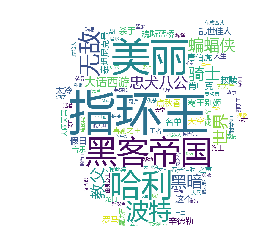

In [44]:
create_word_cloud(words)

### pyecharts 绘制

In [45]:
from pyecharts import options as opts
from pyecharts.charts import Page, WordCloud
from pyecharts.globals import SymbolType


def word_cloud_diamond(words) -> WordCloud:
    """
    pyecharts 绘制所有电影名词云
    :param words: [(word, counts)] 元组列表
    :return: pyecharts wordcloud 对象
    """
    c = (WordCloud().add("",
                         words,
                         word_size_range=[10, 50],
                         shape=SymbolType.DIAMOND).set_global_opts(
                             title_opts=opts.TitleOpts(title="猫眼电影Top100")))
    return c

words = [(i, j) for i, j in zip(df.title[::-1], range(1, 101))]
print(words[:10])
Page().add(word_cloud_diamond(words)).render_notebook()

[('千与千寻', 1), ('龙猫', 2), ('迁徙的鸟', 3), ('黄金三镖客', 4), ('我爱你', 5), ('海洋', 6), ('爱·回家', 7), ('阿飞正传', 8), ('英雄本色', 9), ('一一', 10)]


![image](https://raw.githubusercontent.com/hufe09/maoyan_top100/master/images/word_cloud_echarts.png)

In [46]:
from PIL import Image
img = Image.open("top_100_posters/1.jpg")
print(img.size, img.format, img.mode, img.bits)

(494, 732) JPEG RGB 8


## 组合海报

In [47]:
import os
import math
import random
from PIL import Image


def create_img():
    """
    将每部电影的海报组成成20*5的大海报
    :return: None
    """

    x = 0
    y = 0
    img_dir = 'top_100_posters/'
    images = os.listdir(img_dir)  # 返回目录下的文件列表
    random.shuffle(images)  # 将文件列表随机排序

    width = 200  # 设置单个海报的宽度
    height = int(width * 4 / 3)  # 设置单个图片的高度， 各海报比例设置为4:3
    num_line = 5  # 每行显示图片数
    out_length = int(width * num_line)  # 最终图片的宽度
    out_height = int(height * (len(images) / num_line))  # 最终图片的高度
    new_img = Image.new('RGBA', (out_length, out_height))  # 创建 长*宽 的图片用于填充各小海报

    for i in images:  # 对每一张图片逐个进行处理
        try:
            img = Image.open(img_dir + i)
        except IOError:
            print(f"第{i}张图片为空")  # 可能会出现某张图片为空的情况
        else:
            img = img.resize((width, height), Image.ANTIALIAS)  # 缩小图片
            new_img.paste(img, (x * width, y * height))  # 拼接图片，一行排满，换行拼接
            x += 1
            if x >= num_line:
                x = 0
                y += 1
    print('图片绘制完成')

    new_img.save("images/mixed_posters.png")
    # newImg.show()

create_img()

图片绘制完成


[查看图片](https://raw.githubusercontent.com/hufe09/maoyan_top100/master/images/mixed_posters.png)

## 汇总演员

In [48]:
stars = ','.join(df.stars)
stars = set(stars.split(','))
print(f"Top100的电影中,共有 {len(stars)} 位演员")

Top100的电影中,共有 250 位演员


In [49]:
def count_stars(movies):
    """
    统计每位演员参演的电影及数量
    :param movies: DataFrame  电影数据
    :return: star_movies， 元组列表， 每位演员参演的电影名及数量
    """
    stars = ','.join(movies.stars)
    stars = set(stars.split(','))
    star_movies = {}
    for star in stars:
        titles = []
        for i in range(df.stars.shape[0]):
            if star in df.stars.iloc[i]:
                titles.append(df.title.iloc[i])
        star_movies[star] = len(titles), titles
    star_movies = sorted(star_movies.items(),
                         key=lambda x: x[1][0], reverse=True)
    return star_movies


count_stars(df)

[('张国荣', (7, ['霸王别姬', '春光乍泄', '射雕英雄传之东成西就', '东邪西毒', '倩女幽魂', '英雄本色', '阿飞正传'])),
 ('周星驰', (4, ['唐伯虎点秋香', '喜剧之王', '大话西游之月光宝盒', '大话西游之大圣娶亲'])),
 ('梁朝伟', (4, ['春光乍泄', '射雕英雄传之东成西就', '无间道', '东邪西毒'])),
 ('巩俐', (3, ['霸王别姬', '唐伯虎点秋香', '活着'])),
 ('莫文蔚', (3, ['喜剧之王', '大话西游之月光宝盒', '大话西游之大圣娶亲'])),
 ('丽芙·泰勒', (3, ['指环王3：王者无敌', '指环王1：护戒使者', '指环王2：双塔奇兵'])),
 ('伊恩·麦克莱恩', (3, ['指环王3：王者无敌', '指环王1：护戒使者', '指环王2：双塔奇兵'])),
 ('张曼玉', (3, ['甜蜜蜜', '新龙门客栈', '阿飞正传'])),
 ('伊莱贾·伍德', (3, ['指环王3：王者无敌', '指环王1：护戒使者', '指环王2：双塔奇兵'])),
 ('布拉德·皮特', (3, ['搏击俱乐部', '夜访吸血鬼', '本杰明·巴顿奇事'])),
 ('阿尔·帕西诺', (3, ['教父2', '闻香识女人', '教父'])),
 ('克里斯蒂安·贝尔', (3, ['蝙蝠侠：黑暗骑士', '致命魔术', '蝙蝠侠：黑暗骑士崛起'])),
 ('基努·里维斯', (2, ['黑客帝国', '黑客帝国3：矩阵革命'])),
 ('雨果·维文', (2, ['V字仇杀队', '黑客帝国3：矩阵革命'])),
 ('罗伯特·德尼罗', (2, ['教父2', '美国往事'])),
 ('鲁伯特·格林特', (2, ['哈利·波特与魔法石', '哈利·波特与死亡圣器（下）'])),
 ('雅克·贝汉', (2, ['海洋', '迁徙的鸟'])),
 ('约翰尼·德普', (2, ['剪刀手爱德华', '加勒比海盗'])),
 ('丹尼尔·雷德克里夫', (2, ['哈利·波特与魔法石', '哈利·波特与死亡圣器（下）'])),
 ('希斯·莱杰', (2, ['蝙蝠侠：黑暗骑士', '断背山'])),
 ('凯瑞-安·莫斯', (2

## 探索演员之间的关系

关联规则挖掘可以让我们从数据集中发现项与项（item 与 item）之间的关系，它在我们的生活中有很多应用场景，典型的例子就是啤酒与尿布，“购物篮分析”就是一个常见的场景，这个场景可以从消费者交易记录中发掘商品与商品之间的关联关系，进而通过商品捆绑销售或者相关推荐的方式带来更多的销售量。所以说，关联规则挖掘是个非常有用的技术。

### Apriori 算法实现
apriori()中,其中 data 是我们要提供的数据集，它是一个 list 数组类型。min_support 参数为最小支持度，在 efficient-apriori 工具包中用 0 到 1 的数值代表百分比，比如 0.5 代表最小支持度为 50%。min_confidence 是最小置信度，数值也代表百分比，比如 1 代表 100%。

- **支持度** 指的是某个商品组合出现的次数与总次数之间的比例。支持度越高，代表这个组合出现的概率越大。
- **置信度** 是一个条件概念，就是在 A 发生的情况下，B 发生的概率是多少。
- **提升** 代表的是“商品 A 的出现，对商品 B 的出现概率提升了多少”。


In [50]:
from efficient_apriori import apriori


def stars_relationship(stars):
    """
    探索演员之间的关系
    :param stars: 电影演员
    :return: itemsets_sort: 演员出现频率, rules： 演员之间的频繁项集
    """
    # 数据加载
    data = [names.split(",") for names in stars]
    # 挖掘频繁项集和关联规则
    itemsets, rules = apriori(data, min_support=0.015, min_confidence=1)

    itemsets_sort = {}
    for index, value in itemsets.items():
        itemsets_sort[index] = sorted(value.items(), key=lambda d: d[1], reverse=True)

    return itemsets_sort, rules


stars_relationship = stars_relationship(df.stars)
print("出现频率较高的明星")
stars_relationship[0]

出现频率较高的明星


{1: [(('张国荣',), 7),
  (('周星驰',), 4),
  (('梁朝伟',), 4),
  (('丽芙·泰勒',), 3),
  (('伊恩·麦克莱恩',), 3),
  (('伊莱贾·伍德',), 3),
  (('克里斯蒂安·贝尔',), 3),
  (('巩俐',), 3),
  (('布拉德·皮特',), 3),
  (('张曼玉',), 3),
  (('莫文蔚',), 3),
  (('阿尔·帕西诺',), 3),
  (('丹尼尔·雷德克里夫',), 2),
  (('克林特·伊斯特伍德',), 2),
  (('凯瑞-安·莫斯',), 2),
  (('刘德华',), 2),
  (('加里·奥德曼',), 2),
  (('基努·里维斯',), 2),
  (('姜文',), 2),
  (('娜塔莉·波特曼',), 2),
  (('岛本须美',), 2),
  (('希斯·莱杰',), 2),
  (('约翰尼·德普',), 2),
  (('罗伯特·德尼罗',), 2),
  (('艾玛·沃特森',), 2),
  (('莱昂纳多·迪卡普里奥',), 2),
  (('费雯·丽',), 2),
  (('迈克尔·凯恩',), 2),
  (('雅克·贝汉',), 2),
  (('雨果·维文',), 2),
  (('鲁伯特·格林特',), 2)],
 2: [(('丽芙·泰勒', '伊恩·麦克莱恩'), 3),
  (('丽芙·泰勒', '伊莱贾·伍德'), 3),
  (('伊恩·麦克莱恩', '伊莱贾·伍德'), 3),
  (('周星驰', '莫文蔚'), 3),
  (('张国荣', '梁朝伟'), 3),
  (('丹尼尔·雷德克里夫', '艾玛·沃特森'), 2),
  (('丹尼尔·雷德克里夫', '鲁伯特·格林特'), 2),
  (('克里斯蒂安·贝尔', '迈克尔·凯恩'), 2),
  (('凯瑞-安·莫斯', '基努·里维斯'), 2),
  (('艾玛·沃特森', '鲁伯特·格林特'), 2)],
 3: [(('丽芙·泰勒', '伊恩·麦克莱恩', '伊莱贾·伍德'), 3),
  (('丹尼尔·雷德克里夫', '艾玛·沃特森', '鲁伯特·格林特'), 2)]}

In [51]:
print("频率较高的演员组合")
stars_relationship[1]

频率较高的演员组合


[{艾玛·沃特森} -> {丹尼尔·雷德克里夫},
 {丹尼尔·雷德克里夫} -> {艾玛·沃特森},
 {鲁伯特·格林特} -> {丹尼尔·雷德克里夫},
 {丹尼尔·雷德克里夫} -> {鲁伯特·格林特},
 {伊恩·麦克莱恩} -> {丽芙·泰勒},
 {丽芙·泰勒} -> {伊恩·麦克莱恩},
 {伊莱贾·伍德} -> {丽芙·泰勒},
 {丽芙·泰勒} -> {伊莱贾·伍德},
 {伊莱贾·伍德} -> {伊恩·麦克莱恩},
 {伊恩·麦克莱恩} -> {伊莱贾·伍德},
 {迈克尔·凯恩} -> {克里斯蒂安·贝尔},
 {基努·里维斯} -> {凯瑞-安·莫斯},
 {凯瑞-安·莫斯} -> {基努·里维斯},
 {莫文蔚} -> {周星驰},
 {鲁伯特·格林特} -> {艾玛·沃特森},
 {艾玛·沃特森} -> {鲁伯特·格林特},
 {艾玛·沃特森, 鲁伯特·格林特} -> {丹尼尔·雷德克里夫},
 {丹尼尔·雷德克里夫, 鲁伯特·格林特} -> {艾玛·沃特森},
 {丹尼尔·雷德克里夫, 艾玛·沃特森} -> {鲁伯特·格林特},
 {鲁伯特·格林特} -> {丹尼尔·雷德克里夫, 艾玛·沃特森},
 {艾玛·沃特森} -> {丹尼尔·雷德克里夫, 鲁伯特·格林特},
 {丹尼尔·雷德克里夫} -> {艾玛·沃特森, 鲁伯特·格林特},
 {伊恩·麦克莱恩, 伊莱贾·伍德} -> {丽芙·泰勒},
 {丽芙·泰勒, 伊莱贾·伍德} -> {伊恩·麦克莱恩},
 {丽芙·泰勒, 伊恩·麦克莱恩} -> {伊莱贾·伍德},
 {伊莱贾·伍德} -> {丽芙·泰勒, 伊恩·麦克莱恩},
 {伊恩·麦克莱恩} -> {丽芙·泰勒, 伊莱贾·伍德},
 {丽芙·泰勒} -> {伊恩·麦克莱恩, 伊莱贾·伍德}]

通过取前面自己的统计，以及apriori算法统计，能看出来，猫眼Top100电影中，国内明星 张国荣，周星驰，梁朝伟，莫文蔚，张曼玉，巩俐等知名明星霸榜，国外明星 丽芙·泰勒，伊恩·麦克莱恩，伊莱贾·伍德，克里斯蒂安·贝尔，布拉德·皮特，阿尔·帕西诺 霸榜。

并且，有周星驰的电影基本会有莫文蔚，丽芙·泰勒，伊恩·麦克莱恩，伊莱贾·伍德三人同台的次数也非常多，张国荣，梁朝伟搭戏也必较多。